<a href="https://colab.research.google.com/github/tuliofalmeida/pyjama/blob/main/Pyjama_total_capture_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyJama - Python for Joint Angle Measurement Acquisition Library
##Vicon and Xsens data example

This notebook uses an open source library [tuliofalmeida/pyjama](https://pypi.org/project/pyjamalib/) to estimate knee angle using IMU and video data.

In this example, we present the functionality of PyJama by analyzing data from different sources other than [JAMA](https://github.com/tuliofalmeida/jama). These analysis include data from Vicon's optical device synchronized with Xsens inertial sensors avaiable at [Center for Vision, Speech & Signal Processing - University of Surrey](https://www.surrey.ac.uk/centre-vision-speech-signal-processing).

* Dataset: [Total Capture](https://cvssp.org/data/totalcapture/)
* Reference paper: [Trumble et. al., 2017](https://core.ac.uk/download/pdf/84589062.pdf)

We choose use the walking task data of the individual 1.

Xsens MTw wireless IMU aquisition parameters:
*   Frequency: 60 Hz
*   Aquisition duration: 60s

Vicon Blade parameters:
*   Frequency: 60 Hz
*   Aquisition duration: 60s

For other example notebooks and library details, visit [PyJama GitHub](https://github.com/tuliofalmeida/pyjama).

## Sections


1.   [Install PyJama](#install)
2.   [Imports](#imports)
3.   [Load the data](#load)
4.   [Global variables](#variables)
5.   [Comparsion of data using PyJama](#comparison)
    6. [Original data comparsion](#euler)
    7. [Complementary Filter with Gradient Descent](#cgd)
    8. [Complementary Filter with Gauss-Newton](#cgn)
    7. [Kalman Filter with Gradient Descent](#kgd)
    8. [Kalman Filter with Gauss-Newton](#kgn)
    9. [Madgwick Filter](#mad)

## Install PyJama <a name="install"></a>

In [1]:
!pip install pyjamalib

     |████████████████████████████████| 51kB 3.9MB/s 


## Import the libraries <a name="imports"></a>

In [2]:
import pyjamalib as pjl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext google.colab.data_table

## Load the data <a name="load"></a>

In [3]:
!git clone https://github.com/tuliofalmeida/pyjama

Cloning into 'pyjama'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (262/262), done.
remote: Total 339 (delta 169), reused 160 (delta 52), pack-reused 0
Receiving objects: 100% (339/339), 26.91 MiB | 11.81 MiB/s, done.
Resolving deltas: 100% (169/169), done.


In [4]:
# Data path
path_vicon = '/content/pyjama/docs/total capture/vicon.txt'
path_xsens = '/content/pyjama/docs/total capture/xSens.sensors'

In [5]:
# Saving the variables (body parts) in a dictionary
Vicon_Data = pjl.DataHandler.vicon2dict(path_vicon,60)
Xsens_Data = pjl.DataHandler.xSens2dict(path_xsens,60)

## Global variables <a name="variables"></a>

In [6]:
# Time vector (as the data is synchronized, they have the same time vector)
RUL_Time = Vicon_Data['Time']

# Acquisition frequency
RUL_Freq = 60

# Sample Time
RUL_dt = 1/RUL_Freq

# Vicon original quaternion data
RUL_Vicon = Vicon_Data['RightUpLeg']

# Xsens original quaternion data
RUL_Xsens = Xsens_Data['R_UpLeg']['Quaternion']

# Xsens original accelerometer data
RUL_Acc = Xsens_Data['R_UpLeg']['Accelerometer']

# Xsens original gyroscope data
RUL_Gyr = Xsens_Data['R_UpLeg']['Gyroscope']

# Xsens original magnetometer data
RUL_Mag = Xsens_Data['R_UpLeg']['Magnetometer']

## Comparison of data using PyJama <a name="comparison"></a>

In this section, a dataset containing Xsens IMU raw and orientation quaternions data and Vicon quaternion orientation are used to validate PyJama. We used here the walking task of the individual 1. We used raws Xsens inputs (accelerometer, gyroscope, magnetometer) to estimate orientation in Euler angles and quaternion orientation. PyJama processed outputs were compared with Vicon and Xsens data using error metrics. We choose compare the lower limbs data (Vicon - "RightUpLeg" and Xsens - "R_UpLeg"), in particular, because of the proximity of the optical markers to the sensors on the body, minimizing the orientation error.

### Comparing the Vicon and Xsens original data using PyJama (Quatternion -> Euler -> Quaternion) <a name="euler"></a>

In [7]:
# Xsens transformed to euler
RUL_Xsens_e = np.asarray([pjl.DataProcessing.GetAnglesFromQuaternion(RUL_Xsens[i])for i in range(len(RUL_Xsens))])

# Xsens euler transformed back to quaternion
RUL_Xsens_q = np.asarray([pjl.DataProcessing.GetQuaternionFromAngle(RUL_Xsens_e[i])for i in range(len(RUL_Xsens_e))])

Mean Absolute Percentage Error (MAPE)

In [8]:
# MAPE between the original quaternion orientation extracted by Vicon and the Xsens sensor
Vicon_Xsens_MAPE_q1 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Vicon[:,0],RUL_Xsens[:,0])
Vicon_Xsens_MAPE_q2 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Vicon[:,1],RUL_Xsens[:,1])
Vicon_Xsens_MAPE_q3 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Vicon[:,2],RUL_Xsens[:,2])
Vicon_Xsens_MAPE_q4 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Vicon[:,3],RUL_Xsens[:,3])

# Xsens in raw quaternion and Xsens euler transformed back to quaternion 
RUL_XSENS_MAPE_q1 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,0],RUL_Xsens_q[:,0])
RUL_XSENS_MAPE_q2 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,1],RUL_Xsens_q[:,1])
RUL_XSENS_MAPE_q3 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,2],RUL_Xsens_q[:,2])
RUL_XSENS_MAPE_q4 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,3],RUL_Xsens_q[:,3])

#Xsens in raw quaternion and Xsens euler transformed back to quaternion in absolute values
RUL_XSENS_MAPE_q1_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,0]),abs(RUL_Xsens_q[:,0]))
RUL_XSENS_MAPE_q2_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,1]),abs(RUL_Xsens_q[:,1]))
RUL_XSENS_MAPE_q3_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,2]),abs(RUL_Xsens_q[:,2]))
RUL_XSENS_MAPE_q4_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,3]),abs(RUL_Xsens_q[:,3]))

Comparsion of original data

<Figure size 432x288 with 0 Axes>

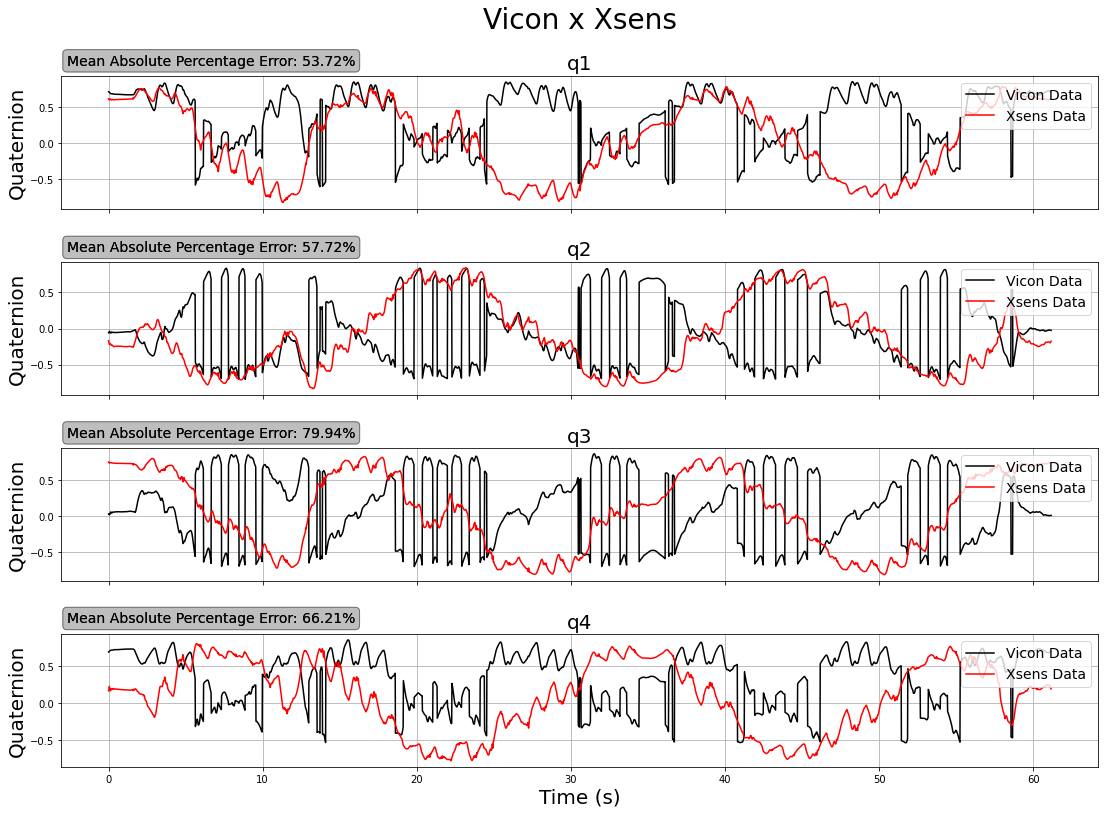

In [9]:
Data = [RUL_Vicon,RUL_Xsens]
Time = RUL_Time
Title = 'Vicon x Xsens'
Box = ["{:.2f}".format(Vicon_Xsens_MAPE_q1),"{:.2f}".format(Vicon_Xsens_MAPE_q2),
       "{:.2f}".format(Vicon_Xsens_MAPE_q3),"{:.2f}".format(Vicon_Xsens_MAPE_q4)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Vicon Data','Xsens Data']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .45

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box)

Comparsion of original Xsens quaternion orientation with Xsens transformation (Quaternion -> Euler -> Quaternion)

<Figure size 432x288 with 0 Axes>

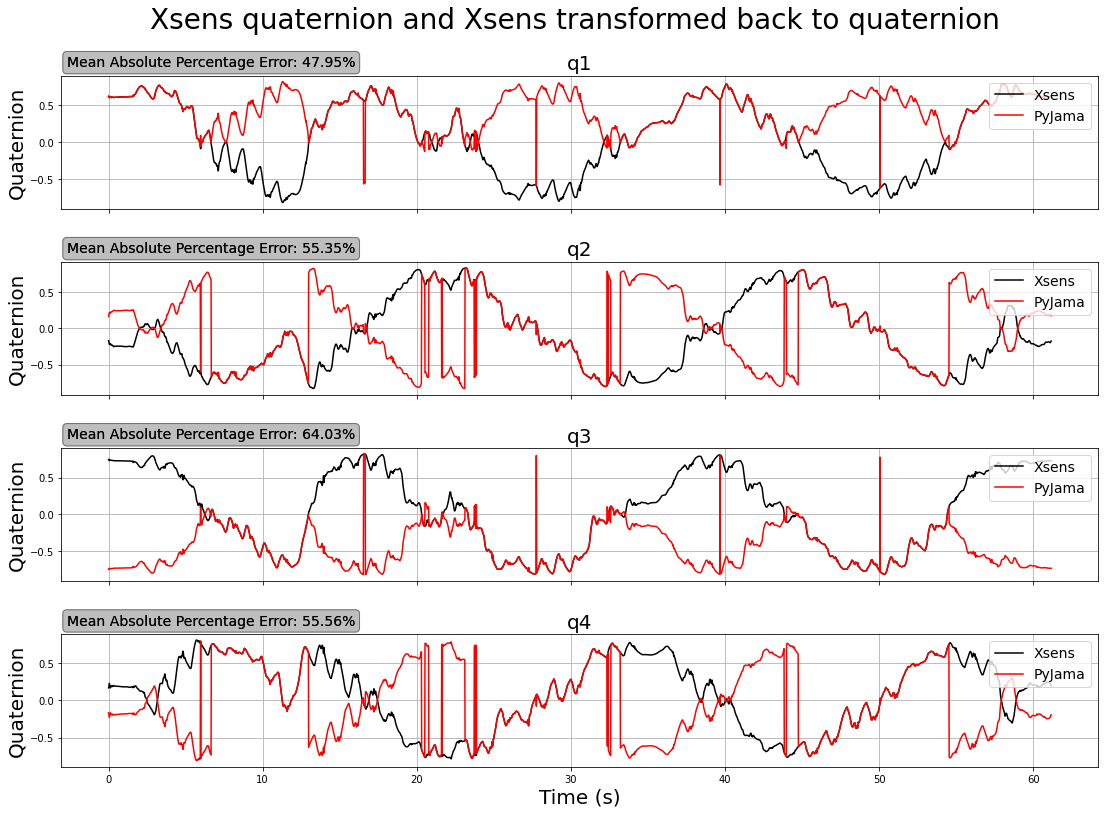

In [10]:
# RUL_Xsens: Original orientation in quaternion
# RUL_Xsens_q: RUL_Xsens transformation to euler and transformed back to quaternion
Data = [RUL_Xsens,RUL_Xsens_q]
Time = RUL_Time 
Title = 'Xsens quaternion and Xsens transformed back to quaternion '
Box = ["{:.2f}".format(RUL_XSENS_MAPE_q1),"{:.2f}".format(RUL_XSENS_MAPE_q2),
       "{:.2f}".format(RUL_XSENS_MAPE_q3),"{:.2f}".format(RUL_XSENS_MAPE_q4)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .43

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);

Comparsion of original Xsens quaternion orientation with Xsens transformation in absolute values

<Figure size 432x288 with 0 Axes>

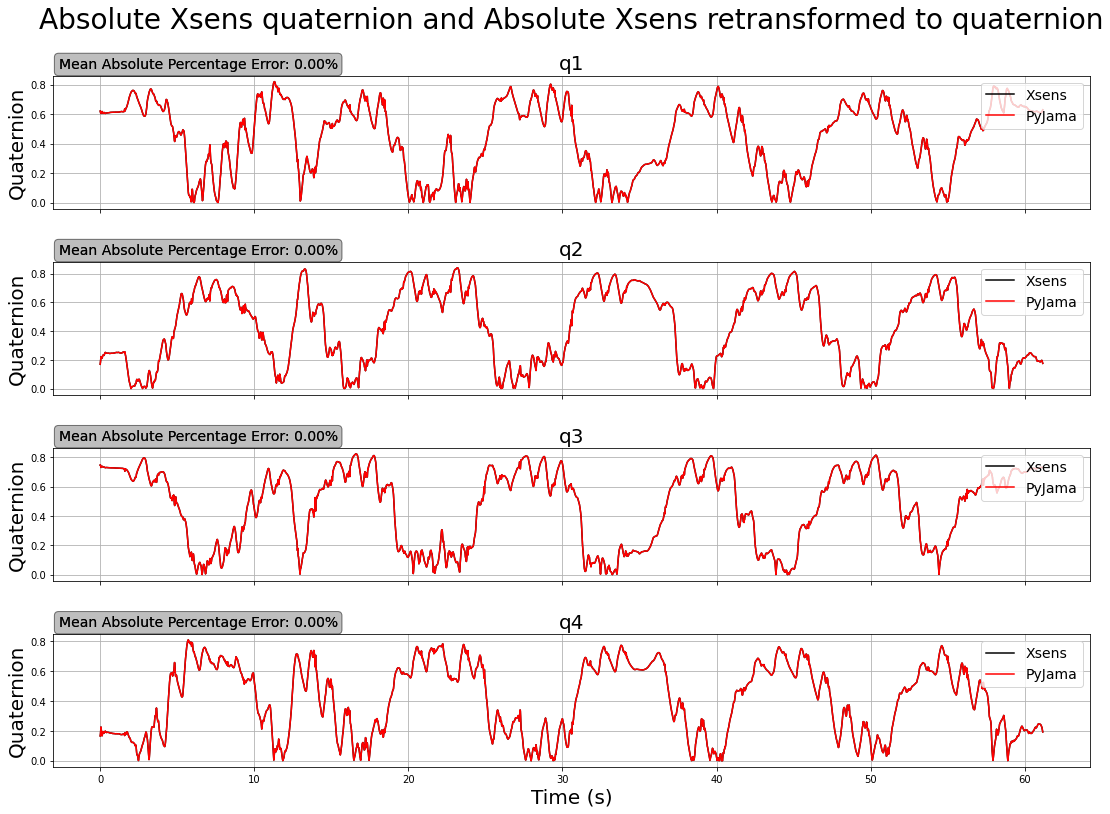

In [11]:
# Using absolute values
Data = [abs(RUL_Xsens),abs(RUL_Xsens_q)]
Time = RUL_Time 
Title = 'Absolute Xsens quaternion and Absolute Xsens retransformed to quaternion' #Xsens euler transformed back to quaternion
Box = ["{:.2f}".format(RUL_XSENS_MAPE_q1_abs),"{:.2f}".format(RUL_XSENS_MAPE_q2_abs),
       "{:.2f}".format(RUL_XSENS_MAPE_q3_abs),"{:.2f}".format(RUL_XSENS_MAPE_q4_abs)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .2

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);

### Complementary Filter using Gradient Descent (CGD) <a name="cgd"></a>

In [12]:
#______________________________________Calculating orientation in euler angles_________________________________________

# RUL_CGD = R_UpLeg orientation in euler using Complementary Filter with Gradient Descent optimizer.
RUL_CGD = pjl.DataProcessing.ComplementaryFilterGN(RUL_Acc,RUL_Gyr,RUL_Mag,dt=RUL_dt,
                                                   conj=False,alpha=0.05,low_pass=.1)
#______________________________________Calculating orientation in quaternions___________________________________________

# RUL_CGD to quaternion
RUL_CGD_q = np.asarray([pjl.DataProcessing.GetQuaternionFromAngle(RUL_CGD[i])for i in range(len(RUL_CGD))])

Mean Absolute Percentage Error (MAPE)

In [13]:
# Xsens transformed in euler and PyJama calculation using raw data
RUL_CGD_MAPE_R = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,0],RUL_CGD[:,0])
RUL_CGD_MAPE_P = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,1],RUL_CGD[:,1])
RUL_CGD_MAPE_Y = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,2],RUL_CGD[:,2])

# Xsens in raw quaternion and PyJama calculation transformed in quaternion
RUL_CGD_MAPE_q1 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,0],RUL_CGD_q[:,0])
RUL_CGD_MAPE_q2 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,1],RUL_CGD_q[:,1])
RUL_CGD_MAPE_q3 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,2],RUL_CGD_q[:,2])
RUL_CGD_MAPE_q4 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,3],RUL_CGD_q[:,3])

# Xsens in raw quaternion and PyJama calculation transformed in quaternion in absolute values
RUL_CGD_MAPE_q1_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,0]),abs(RUL_CGD_q[:,0]))
RUL_CGD_MAPE_q2_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,1]),abs(RUL_CGD_q[:,1]))
RUL_CGD_MAPE_q3_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,2]),abs(RUL_CGD_q[:,2]))
RUL_CGD_MAPE_q4_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,3]),abs(RUL_CGD_q[:,3]))

Euler comparsion (calculated [here](#euler))

<Figure size 432x288 with 0 Axes>

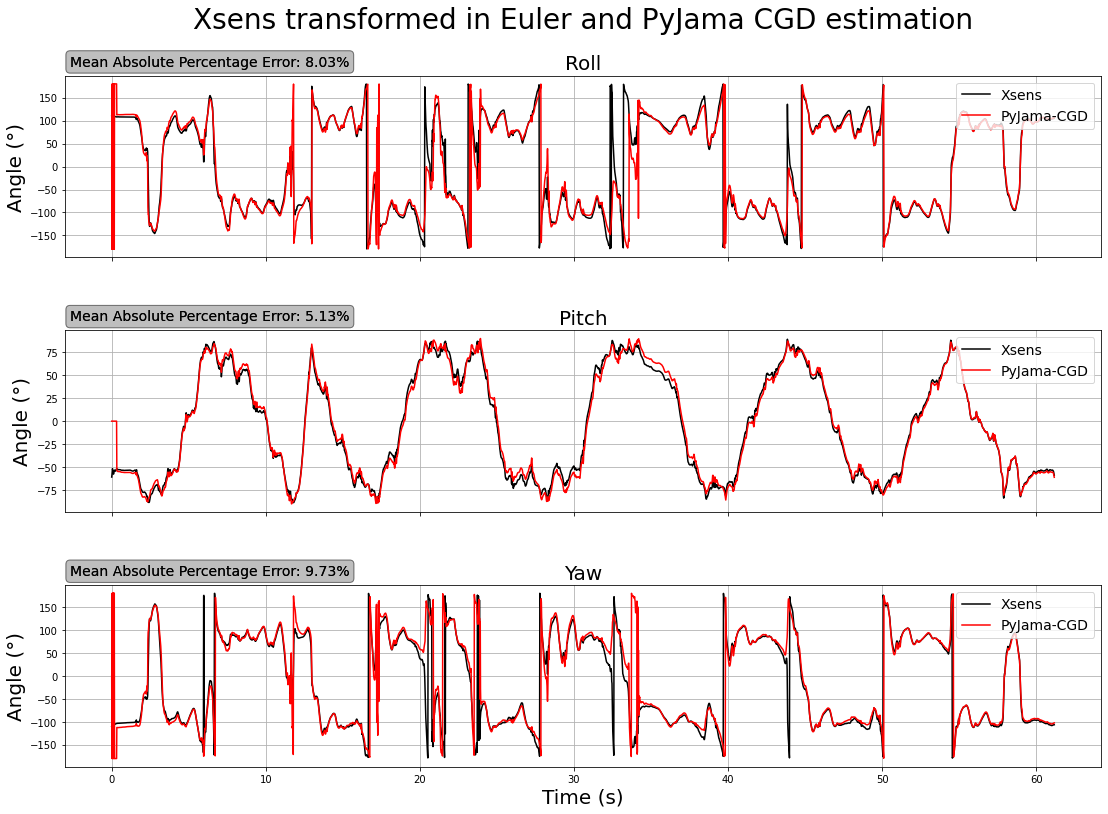

In [14]:
# RUL_Xsens: Xsens data transformed to euler
# RUL_CGD: Estimation of Euler angles using Xsens data(Acc,Gyr,Mag)
Data = [RUL_Xsens_e,RUL_CGD]
Time = RUL_Time
Title = 'Xsens transformed in Euler and PyJama CGD estimation'
Box = ["{:.2f}".format(RUL_CGD_MAPE_R),
       "{:.2f}".format(RUL_CGD_MAPE_P),
       "{:.2f}".format(RUL_CGD_MAPE_Y)]
Label_y = 'Angle (°)'
Subplot_title = ['Roll','Pitch','Yaw']
Legend = ['Xsens','PyJama-CGD']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .35

pjl.DataPlot.pyjama_subplot(Data,Time,box_data=Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                          labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box)

Quaternion comparsion

<Figure size 432x288 with 0 Axes>

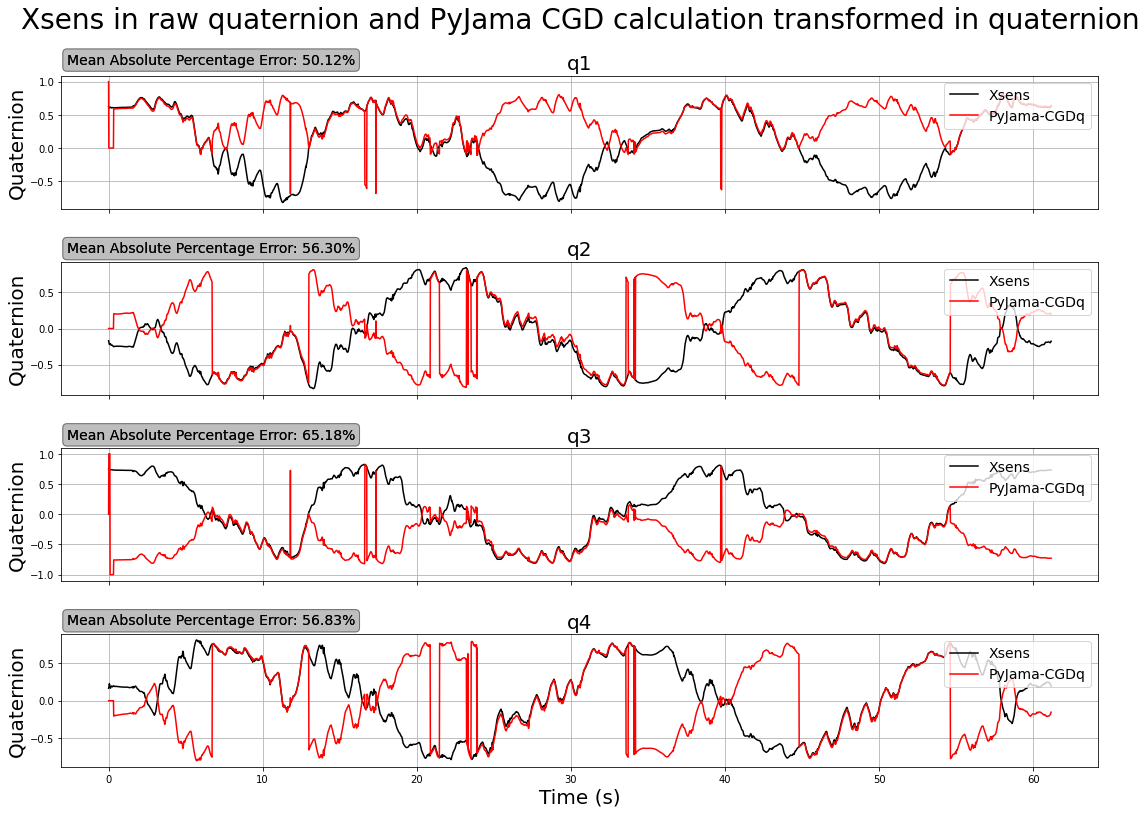

In [15]:
# RUL_Xsens: Xsens original quaternion
# RUL_CGD_q: Pyjama calculation in Euler transformed to quaternion
Data = [RUL_Xsens,RUL_CGD_q] 
Time = RUL_Time
Title = 'Xsens in raw quaternion and PyJama CGD calculation transformed in quaternion'
Box = ["{:.2f}".format(RUL_CGD_MAPE_q1),"{:.2f}".format(RUL_CGD_MAPE_q2),
       "{:.2f}".format(RUL_CGD_MAPE_q3),"{:.2f}".format(RUL_CGD_MAPE_q4)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama-CGDq']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .43

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);

<Figure size 432x288 with 0 Axes>

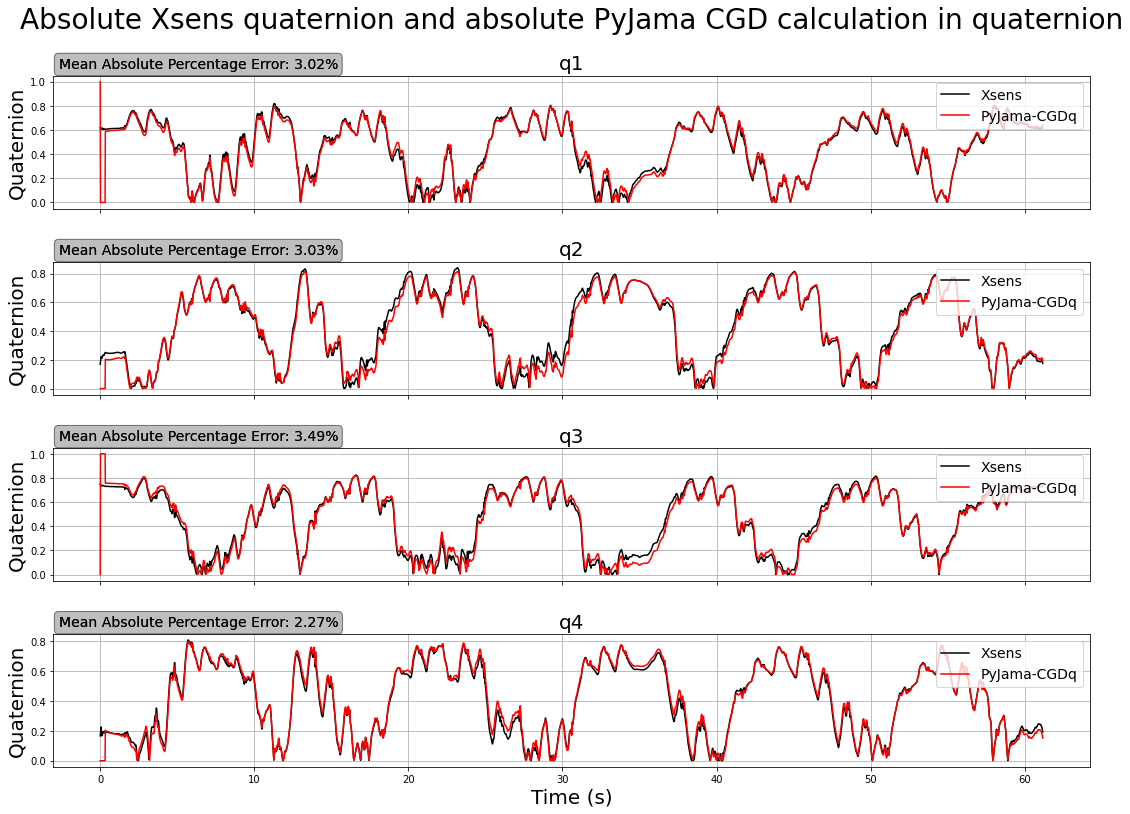

In [16]:
# Using absolute quaternion values
Data = [abs(RUL_Xsens),abs(RUL_CGD_q)]
Time = RUL_Time
Title = 'Absolute Xsens quaternion and absolute PyJama CGD calculation in quaternion'
Box = ["{:.2f}".format(RUL_CGD_MAPE_q1_abs),"{:.2f}".format(RUL_CGD_MAPE_q2_abs),
       "{:.2f}".format(RUL_CGD_MAPE_q3_abs),"{:.2f}".format(RUL_CGD_MAPE_q4_abs)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama-CGDq']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .2

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);

### Complementary Filter using Gauss-Newton (CGN) <a name="cgn"></a>

In [17]:
#______________________________________Calculating orientation in euler angles_________________________________________

# RUL_CGN = R_UpLeg orientation in euler using Complementary Filter with Gauss-Newton optimizer.
RUL_CGN = pjl.DataProcessing.ComplementaryFilterGN(RUL_Acc,RUL_Gyr,RUL_Mag,dt=RUL_dt,
                                                   conj=False,alpha=0.05,low_pass=.1) 
#______________________________________Calculating orientation in quaternions___________________________________________

# RUL_CGN to quaternion
RUL_CGN_q = np.asarray([pjl.DataProcessing.GetQuaternionFromAngle(RUL_CGN[i])for i in range(len(RUL_CGN))])

Mean Absolute Percentage Error (MAPE)

In [18]:
# Xsens transformed in euler and PyJama calculation using raw data
RUL_CGN_MAPE_R = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,0],RUL_CGN[:,0])
RUL_CGN_MAPE_P = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,1],RUL_CGN[:,1])
RUL_CGN_MAPE_Y = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,2],RUL_CGN[:,2])

# Xsens in raw quaternion and PyJama calculation transformed in quaternion
RUL_CGN_MAPE_q1 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,0],RUL_CGN_q[:,0])
RUL_CGN_MAPE_q2 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,1],RUL_CGN_q[:,1])
RUL_CGN_MAPE_q3 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,2],RUL_CGN_q[:,2])
RUL_CGN_MAPE_q4 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,3],RUL_CGN_q[:,3])

# Xsens in raw quaternion and PyJama calculation transformed in quaternion in absolute values
RUL_CGN_MAPE_q1_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,0]),abs(RUL_CGN_q[:,0]))
RUL_CGN_MAPE_q2_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,1]),abs(RUL_CGN_q[:,1]))
RUL_CGN_MAPE_q3_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,2]),abs(RUL_CGN_q[:,2]))
RUL_CGN_MAPE_q4_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,3]),abs(RUL_CGN_q[:,3]))

Euler comparsion (calculated [here](#euler))

<Figure size 432x288 with 0 Axes>

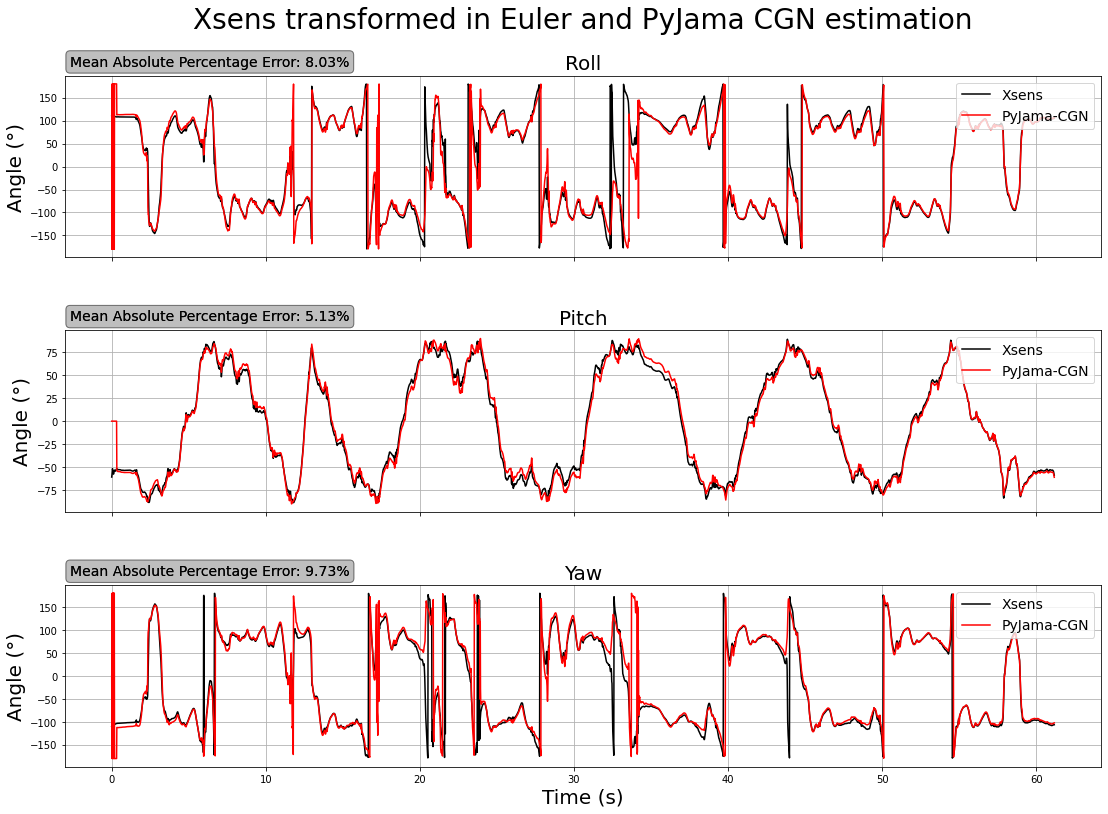

In [19]:
# RUL_Xsens: Xsens data transformed to euler
# RUL_CGN: Estimation of Euler angles using Xsens data(Acc,Gyr,Mag)
Data = [RUL_Xsens_e,RUL_CGN]
Time = RUL_Time
Title = 'Xsens transformed in Euler and PyJama CGN estimation'
Box = ["{:.2f}".format(RUL_CGN_MAPE_R),
       "{:.2f}".format(RUL_CGN_MAPE_P),
       "{:.2f}".format(RUL_CGN_MAPE_Y)]
Label_y = 'Angle (°)'
Subplot_title = ['Roll','Pitch','Yaw']
Legend = ['Xsens','PyJama-CGN']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .35

pjl.DataPlot.pyjama_subplot(Data,Time,box_data=Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                          labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box)

Quaternion comparsion

<Figure size 432x288 with 0 Axes>

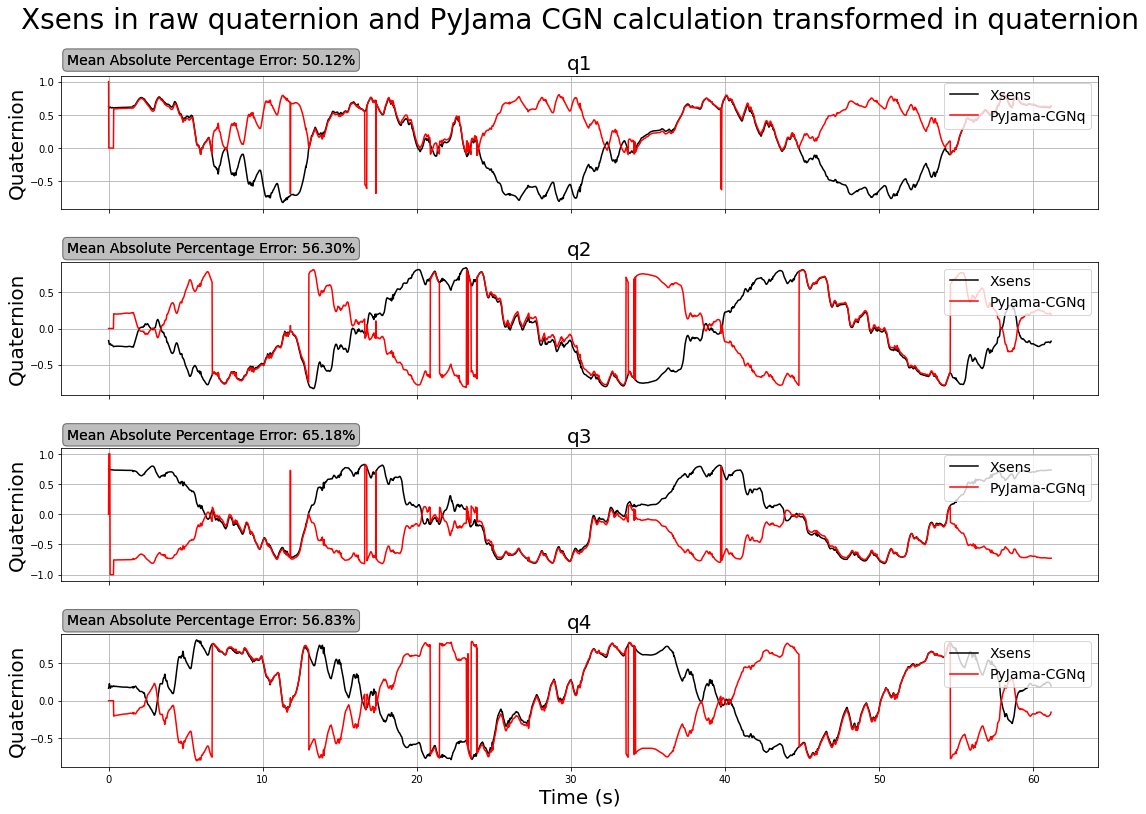

In [20]:
# RUL_Xsens: Xsens original quaternion
# RUL_CGN_q: Pyjama calculation in Euler transformed to quaternion
Data = [RUL_Xsens,RUL_CGN_q] 
Time = RUL_Time
Title = 'Xsens in raw quaternion and PyJama CGN calculation transformed in quaternion'
Box = ["{:.2f}".format(RUL_CGN_MAPE_q1),"{:.2f}".format(RUL_CGN_MAPE_q2),
       "{:.2f}".format(RUL_CGN_MAPE_q3),"{:.2f}".format(RUL_CGN_MAPE_q4)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama-CGNq']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .43

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);

<Figure size 432x288 with 0 Axes>

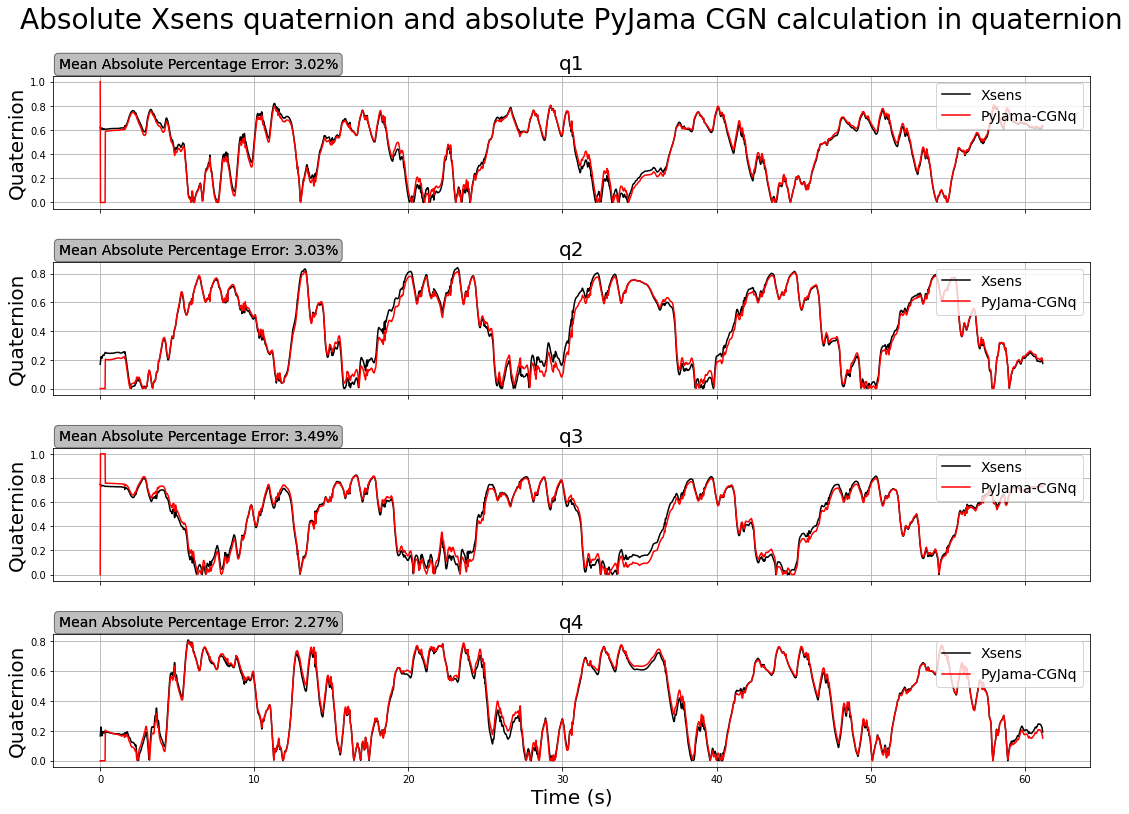

In [21]:
# Using absolute quaternion values
Data = [abs(RUL_Xsens),abs(RUL_CGN_q)]
Time = RUL_Time
Title = 'Absolute Xsens quaternion and absolute PyJama CGN calculation in quaternion'
Box = ["{:.2f}".format(RUL_CGN_MAPE_q1_abs),"{:.2f}".format(RUL_CGN_MAPE_q2_abs),
       "{:.2f}".format(RUL_CGN_MAPE_q3_abs),"{:.2f}".format(RUL_CGN_MAPE_q4_abs)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama-CGNq']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .2

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);

### Kalman Filter using Gradient Descent (KGD) <a name="kgd"></a>

In [22]:
#______________________________________Calculating orientation in euler angles_________________________________________

# RUL_KGD = R_UpLeg orientation in euler using Kalman Filter with Gradient Descent optimizer.
RUL_KGD = pjl.DataProcessing.KalmanGD(RUL_Acc,RUL_Gyr,RUL_Mag,dt=RUL_dt,
                                      conj=False,beta=0.5,low_pass=.05)

#______________________________________Calculating orientation in quaternions___________________________________________

# RUL_KGD to quaternion
RUL_KGD_q = np.asarray([pjl.DataProcessing.GetQuaternionFromAngle(RUL_KGD[i])for i in range(len(RUL_KGD))])

Mean Absolute Percentage Error (MAPE)

In [23]:
# Xsens transformed in euler and PyJama calculation using raw data
RUL_KGD_MAPE_R = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,0],RUL_KGD[:,0])
RUL_KGD_MAPE_P = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,1],RUL_KGD[:,1])
RUL_KGD_MAPE_Y = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,2],RUL_KGD[:,2])

# Xsens in raw quaternion and PyJama calculation transformed in quaternion
RUL_KGD_MAPE_q1 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,0],RUL_KGD_q[:,0])
RUL_KGD_MAPE_q2 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,1],RUL_KGD_q[:,1])
RUL_KGD_MAPE_q3 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,2],RUL_KGD_q[:,2])
RUL_KGD_MAPE_q4 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,3],RUL_KGD_q[:,3])

# Xsens in raw quaternion and PyJama calculation transformed in quaternion in absolute values
RUL_KGD_MAPE_q1_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,0]),abs(RUL_KGD_q[:,0]))
RUL_KGD_MAPE_q2_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,1]),abs(RUL_KGD_q[:,1]))
RUL_KGD_MAPE_q3_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,2]),abs(RUL_KGD_q[:,2]))
RUL_KGD_MAPE_q4_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,3]),abs(RUL_KGD_q[:,3]))

Euler comparsion (calculated [here](#euler))

<Figure size 432x288 with 0 Axes>

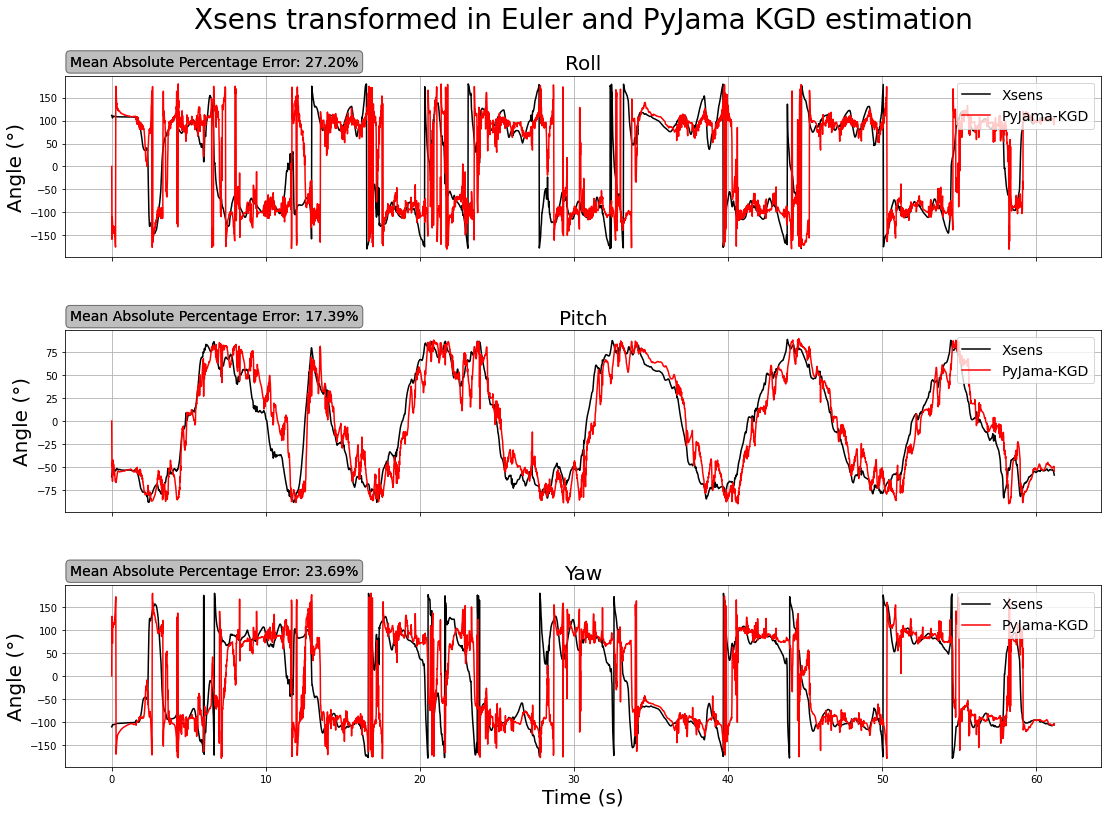

In [24]:
# RUL_Xsens: Xsens data transformed to euler
# RUL_KGD: Estimation of Euler angles using Xsens data(Acc,Gyr,Mag)
Data = [RUL_Xsens_e,RUL_KGD]
Time = RUL_Time
Title = 'Xsens transformed in Euler and PyJama KGD estimation'
Box = ["{:.2f}".format(RUL_KGD_MAPE_R),
       "{:.2f}".format(RUL_KGD_MAPE_P),
       "{:.2f}".format(RUL_KGD_MAPE_Y)]
Label_y = 'Angle (°)'
Subplot_title = ['Roll','Pitch','Yaw']
Legend = ['Xsens','PyJama-KGD']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .35

pjl.DataPlot.pyjama_subplot(Data,Time,box_data=Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                          labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box)

Quaternion comparsion

<Figure size 432x288 with 0 Axes>

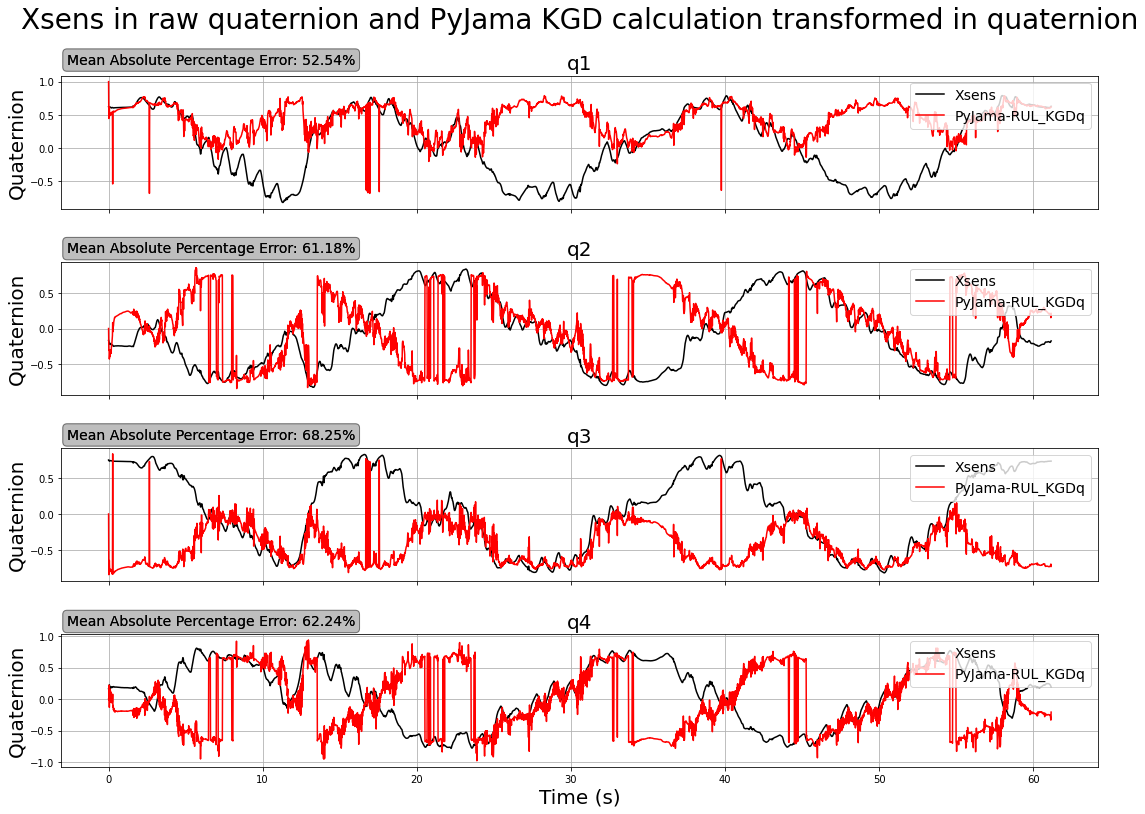

In [25]:
# RUL_Xsens: Xsens original quaternion
# RUL_KGD_q: Pyjama calculation in Euler transformed to quaternion
Data = [RUL_Xsens,RUL_KGD_q] 
Time = RUL_Time
Title = 'Xsens in raw quaternion and PyJama KGD calculation transformed in quaternion'
Box = ["{:.2f}".format(RUL_KGD_MAPE_q1),"{:.2f}".format(RUL_KGD_MAPE_q2),
       "{:.2f}".format(RUL_KGD_MAPE_q3),"{:.2f}".format(RUL_KGD_MAPE_q4)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama-RUL_KGDq']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .43

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);

<Figure size 432x288 with 0 Axes>

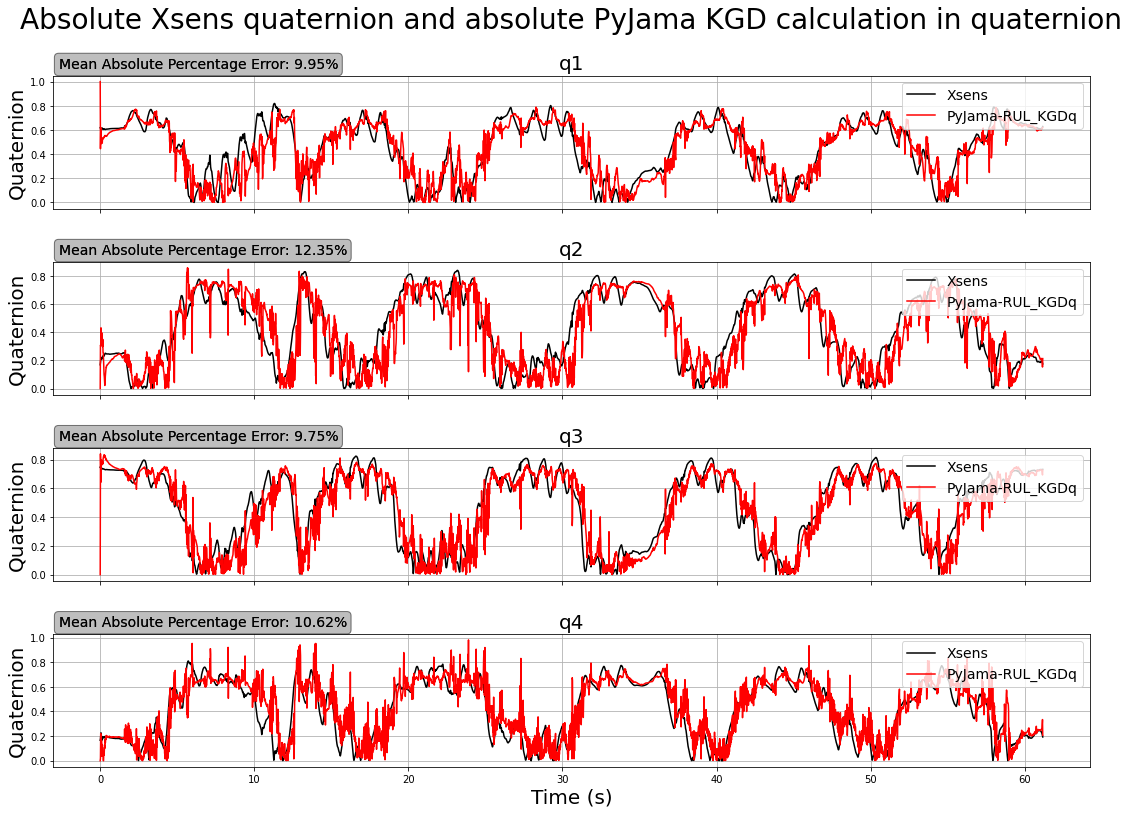

In [26]:
# Using absolute quaternion values
Data = [abs(RUL_Xsens),abs(RUL_KGD_q)]
Time = RUL_Time
Title = 'Absolute Xsens quaternion and absolute PyJama KGD calculation in quaternion'
Box = ["{:.2f}".format(RUL_KGD_MAPE_q1_abs),"{:.2f}".format(RUL_KGD_MAPE_q2_abs),
       "{:.2f}".format(RUL_KGD_MAPE_q3_abs),"{:.2f}".format(RUL_KGD_MAPE_q4_abs)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama-RUL_KGDq']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .2

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);

### Kalman Filter using Gauss-Newton (KGN) <a name="kgn"></a>

In [27]:
#______________________________________Calculating orientation in euler angles_________________________________________

# RUL_KGN = R_UpLeg orientation in euler using Kalman Filter with Gauss-Newton optimizer.
RUL_KGN = pjl.DataProcessing.KalmanGN(RUL_Acc,RUL_Gyr,RUL_Mag,dt=RUL_dt,
                                      conj=False,beta=0.5,low_pass=.05)

#______________________________________Calculating orientation in quaternions___________________________________________

# RUL_CGN to quaternion
RUL_KGN_q = np.asarray([pjl.DataProcessing.GetQuaternionFromAngle(RUL_KGN[i])for i in range(len(RUL_KGN))])

Mean Absolute Percentage Error (MAPE)

In [28]:
# Xsens transformed in euler and PyJama calculation using raw data
RUL_KGN_MAPE_R = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,0],RUL_KGN[:,0])
RUL_KGN_MAPE_P = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,1],RUL_KGN[:,1])
RUL_KGN_MAPE_Y = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,2],RUL_KGN[:,2])

# Xsens in raw quaternion and PyJama calculation transformed in quaternion
RUL_KGN_MAPE_q1 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,0],RUL_KGN_q[:,0])
RUL_KGN_MAPE_q2 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,1],RUL_KGN_q[:,1])
RUL_KGN_MAPE_q3 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,2],RUL_KGN_q[:,2])
RUL_KGN_MAPE_q4 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,3],RUL_KGN_q[:,3])

# Xsens in raw quaternion and PyJama calculation transformed in quaternion in absolute values
RUL_KGN_MAPE_q1_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,0]),abs(RUL_KGN_q[:,0]))
RUL_KGN_MAPE_q2_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,1]),abs(RUL_KGN_q[:,1]))
RUL_KGN_MAPE_q3_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,2]),abs(RUL_KGN_q[:,2]))
RUL_KGN_MAPE_q4_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,3]),abs(RUL_KGN_q[:,3]))

Euler comparsion (calculated [here](#euler))

<Figure size 432x288 with 0 Axes>

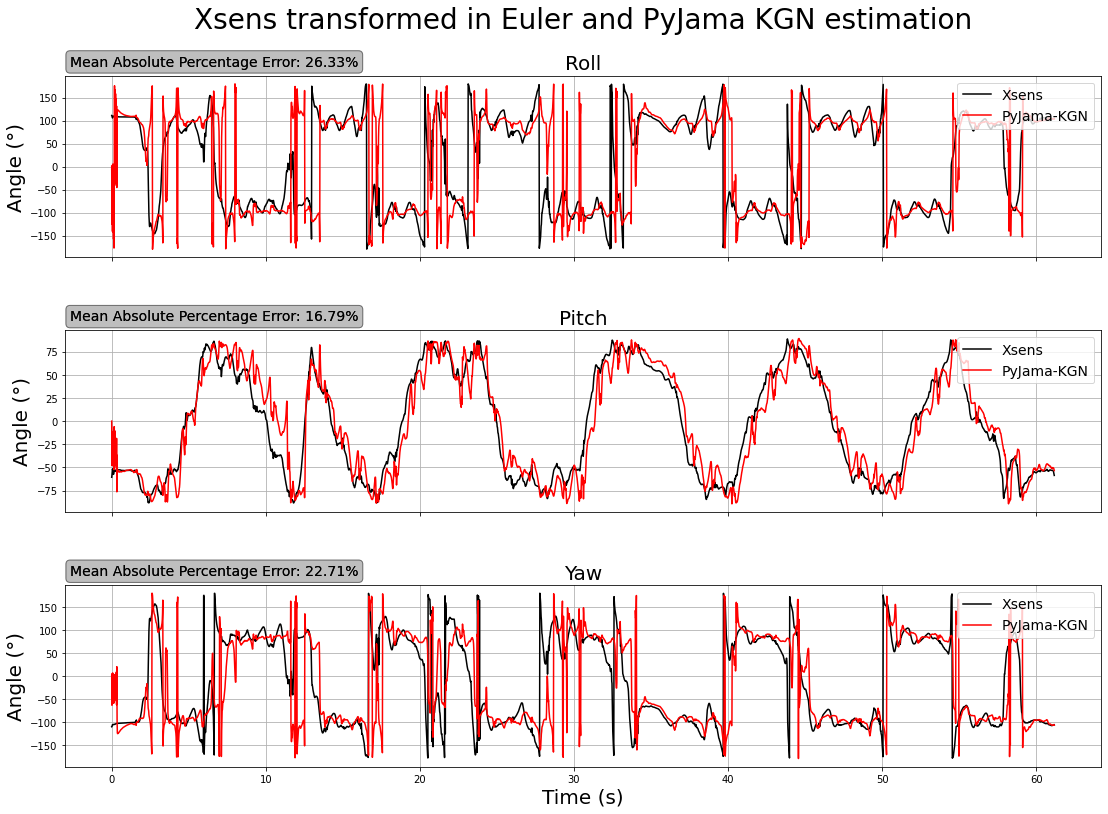

In [29]:
# RUL_Xsens: Xsens data transformed to euler
# RUL_KGN: Estimation of Euler angles using Xsens data(Acc,Gyr,Mag)
Data = [RUL_Xsens_e,RUL_KGN]
Time = RUL_Time
Title = 'Xsens transformed in Euler and PyJama KGN estimation'
Box = ["{:.2f}".format(RUL_KGN_MAPE_R),
       "{:.2f}".format(RUL_KGN_MAPE_P),
       "{:.2f}".format(RUL_KGN_MAPE_Y)]
Label_y = 'Angle (°)'
Subplot_title = ['Roll','Pitch','Yaw']
Legend = ['Xsens','PyJama-KGN']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .35

pjl.DataPlot.pyjama_subplot(Data,Time,box_data=Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                          labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box)

Quaternion comparsion

<Figure size 432x288 with 0 Axes>

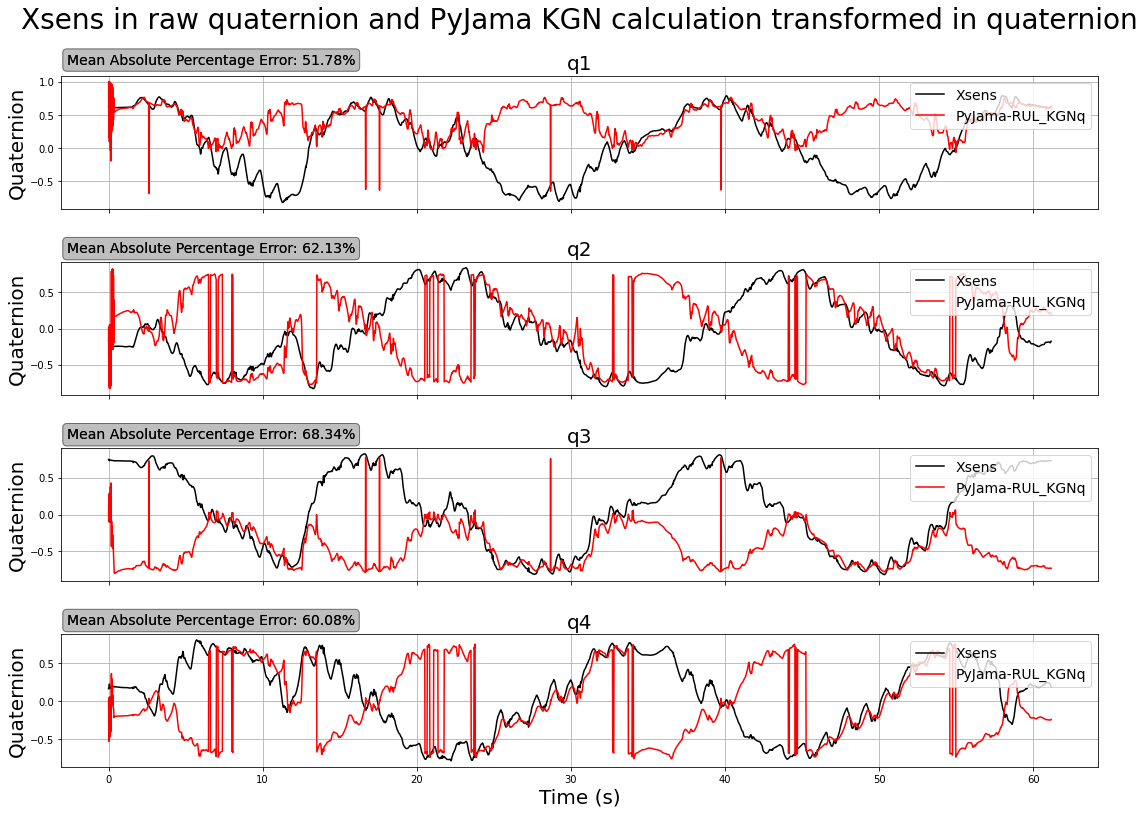

In [30]:
# RUL_Xsens: Xsens original quaternion
# RUL_KGN_q: Pyjama calculation in Euler transformed to quaternion
Data = [RUL_Xsens,RUL_KGN_q] 
Time = RUL_Time
Title = 'Xsens in raw quaternion and PyJama KGN calculation transformed in quaternion'
Box = ["{:.2f}".format(RUL_KGN_MAPE_q1),"{:.2f}".format(RUL_KGN_MAPE_q2),
       "{:.2f}".format(RUL_KGN_MAPE_q3),"{:.2f}".format(RUL_KGN_MAPE_q4)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama-RUL_KGNq']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .43

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);

<Figure size 432x288 with 0 Axes>

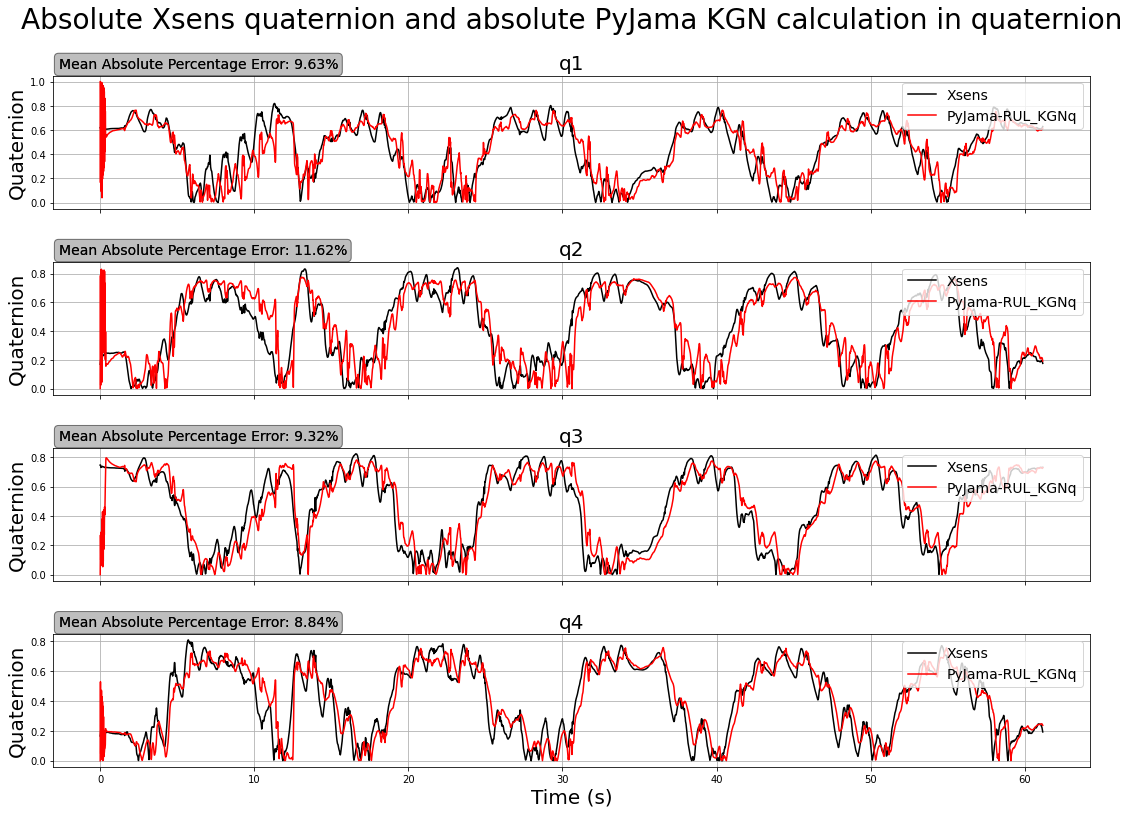

In [31]:
# Using absolute quaternion values
Data = [abs(RUL_Xsens),abs(RUL_KGN_q)]
Time = RUL_Time
Title = 'Absolute Xsens quaternion and absolute PyJama KGN calculation in quaternion'
Box = ["{:.2f}".format(RUL_KGN_MAPE_q1_abs),"{:.2f}".format(RUL_KGN_MAPE_q2_abs),
       "{:.2f}".format(RUL_KGN_MAPE_q3_abs),"{:.2f}".format(RUL_KGN_MAPE_q4_abs)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama-RUL_KGNq']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .2

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);

### MadgwickAHRS Filter (MAD) <a name="mad"></a>

In [32]:
#______________________________________Calculating orientation in euler angles_________________________________________

# RUL_MAD = R_UpLeg orientation in euler using MadgwickAHRS Filter.
RUL_MAD = pjl.DataProcessing.MadgwickAHRS(RUL_Acc,RUL_Gyr,RUL_Mag,freq=RUL_Freq,
                                          conj=False)

#______________________________________Calculating orientation in quaternions___________________________________________

# RUL_MAD to quaternion
RUL_MAD_q = np.asarray([pjl.DataProcessing.GetQuaternionFromAngle(RUL_MAD[i])for i in range(len(RUL_MAD))])

Mean Absolute Percentage Error (MAPE)

In [33]:
# Xsens transformed in euler and PyJama calculation using raw data
RUL_MAD_MAPE_R = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,0],RUL_MAD[:,0])
RUL_MAD_MAPE_P = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,1],RUL_MAD[:,1])
RUL_MAD_MAPE_Y = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens_e[:,2],RUL_MAD[:,2])

# Xsens in raw quaternion and PyJama calculation transformed in quaternion
RUL_MAD_MAPE_q1 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,0],RUL_MAD_q[:,0])
RUL_MAD_MAPE_q2 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,1],RUL_MAD_q[:,1])
RUL_MAD_MAPE_q3 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,2],RUL_MAD_q[:,2])
RUL_MAD_MAPE_q4 = pjl.DataProcessing.mean_absolute_percentage_error(RUL_Xsens[:,3],RUL_MAD_q[:,3])

# Xsens in raw quaternion and PyJama calculation transformed in quaternion in absolute values
RUL_MAD_MAPE_q1_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,0]),abs(RUL_MAD_q[:,0]))
RUL_MAD_MAPE_q2_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,1]),abs(RUL_MAD_q[:,1]))
RUL_MAD_MAPE_q3_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,2]),abs(RUL_MAD_q[:,2]))
RUL_MAD_MAPE_q4_abs = pjl.DataProcessing.mean_absolute_percentage_error(abs(RUL_Xsens[:,3]),abs(RUL_MAD_q[:,3]))

Euler comparsion (calculated [here](#euler))

<Figure size 432x288 with 0 Axes>

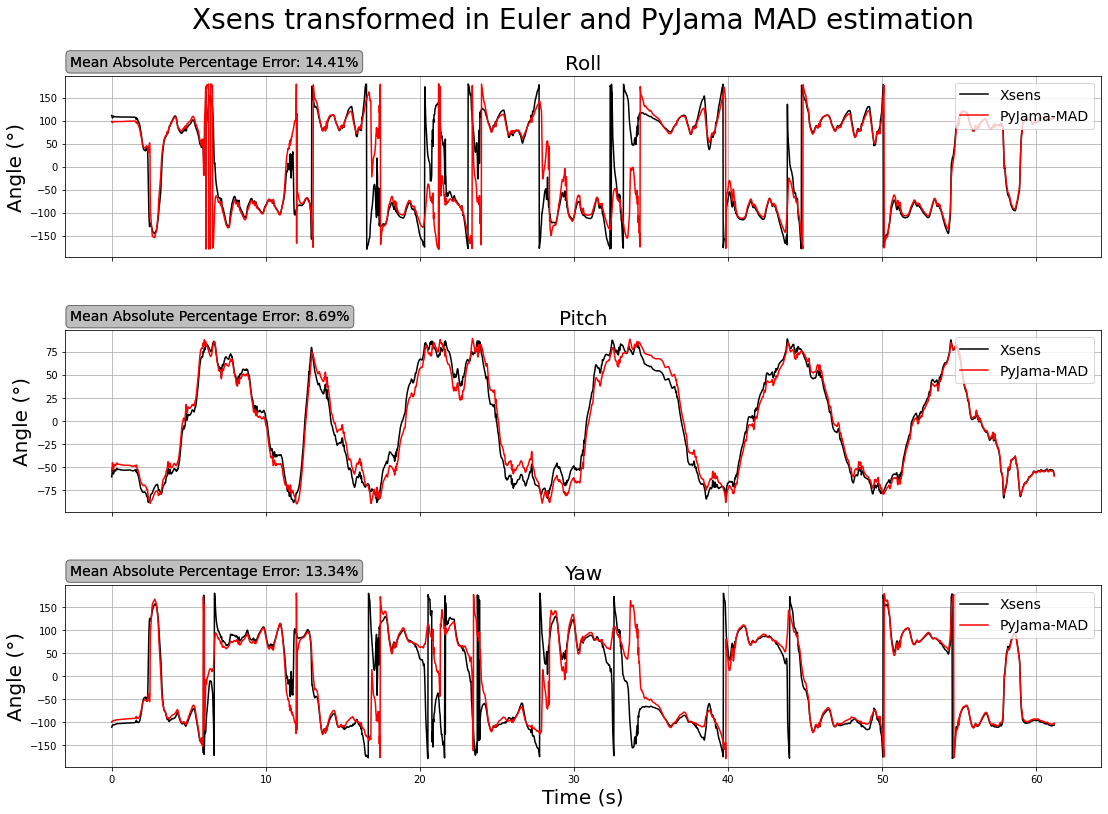

In [34]:
# RUL_Xsens: Xsens data transformed to euler
# RUL_MAD: Estimation of Euler angles using Xsens data(Acc,Gyr,Mag)
Data = [RUL_Xsens_e,RUL_MAD]
Time = RUL_Time
Title = 'Xsens transformed in Euler and PyJama MAD estimation'
Box = ["{:.2f}".format(RUL_MAD_MAPE_R),
       "{:.2f}".format(RUL_MAD_MAPE_P),
       "{:.2f}".format(RUL_MAD_MAPE_Y)]
Label_y = 'Angle (°)'
Subplot_title = ['Roll','Pitch','Yaw']
Legend = ['Xsens','PyJama-MAD']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .35

pjl.DataPlot.pyjama_subplot(Data,Time,box_data=Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                          labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box)

Quaternion comparsion

<Figure size 432x288 with 0 Axes>

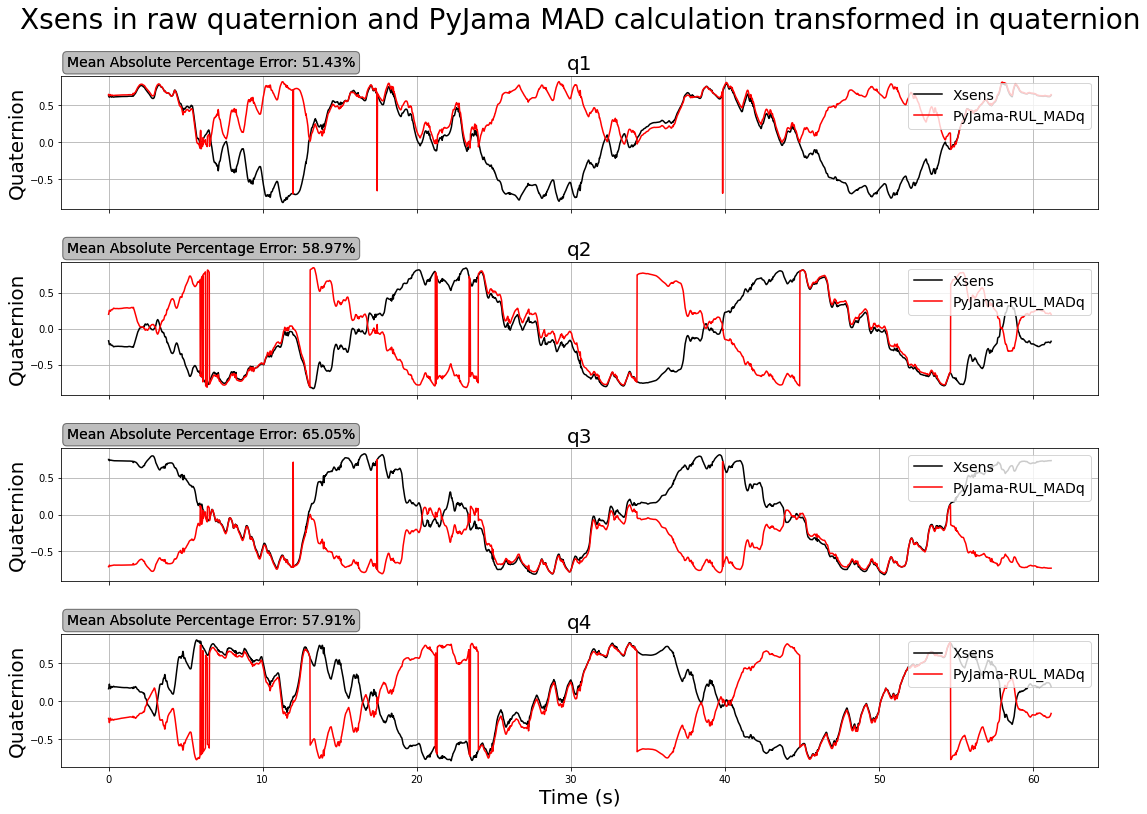

In [35]:
# RUL_Xsens: Xsens original quaternion
# RUL_MAD_q: Pyjama calculation in Euler transformed to quaternion
Data = [RUL_Xsens,RUL_MAD_q] 
Time = RUL_Time
Title = 'Xsens in raw quaternion and PyJama MAD calculation transformed in quaternion'
Box = ["{:.2f}".format(RUL_MAD_MAPE_q1),"{:.2f}".format(RUL_MAD_MAPE_q2),
       "{:.2f}".format(RUL_MAD_MAPE_q3),"{:.2f}".format(RUL_MAD_MAPE_q4)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama-RUL_MADq']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .43

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);

<Figure size 432x288 with 0 Axes>

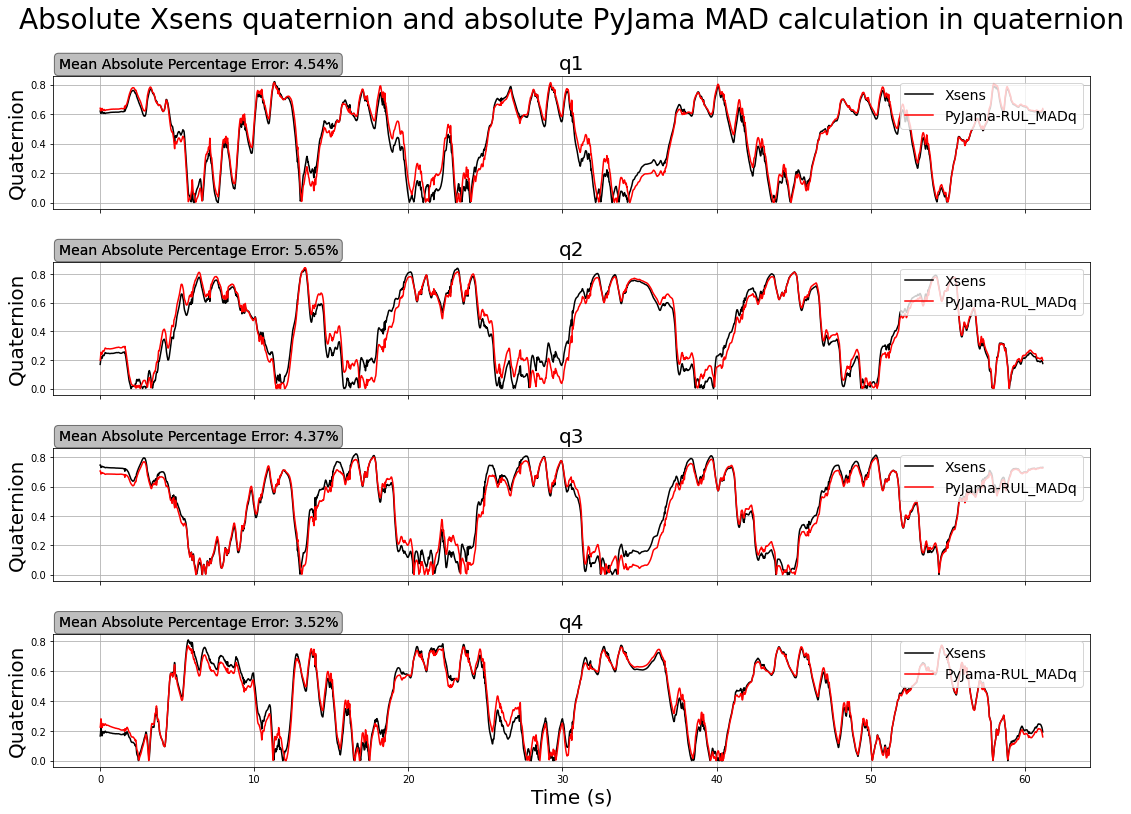

In [36]:
# Using absolute quaternion values
Data = [abs(RUL_Xsens),abs(RUL_MAD_q)]
Time = RUL_Time
Title = 'Absolute Xsens quaternion and absolute PyJama MAD calculation in quaternion'
Box = ["{:.2f}".format(RUL_MAD_MAPE_q1_abs),"{:.2f}".format(RUL_MAD_MAPE_q2_abs),
       "{:.2f}".format(RUL_MAD_MAPE_q3_abs),"{:.2f}".format(RUL_MAD_MAPE_q4_abs)]
Label_y = 'Quaternion'
Subplot_title = ['q1','q2','q3','q4']
Legend = ['Xsens','PyJama-RUL_MADq']
Box_text_b = "Mean Absolute Percentage Error: "
Box_text_a = "%"
H_box = .2

pjl.DataPlot.pyjama_subplot(Data,Time,Box,title=Title,y_label=Label_y,data_name=Subplot_title,
                            labels=Legend,box_text_b=Box_text_b,box_text_a=Box_text_a,h_box=H_box);